In [1]:
# !pip3 install --upgrade torch --user
# !pip3 install torchvision --user

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle
import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.nn.parameter import Parameter
import math
from torch.nn.modules.utils import _pair




from torchvision import datasets
from torchvision import transforms
from PIL import Image


from utils.model_utils import PatchLoader, NonLocalAggregation
from utils.martemev_utils import compute_psnr, get_freer_gpu, get_closest_diff

from time import time

# model[0].weight.grad

In [2]:
# !rm -r ./TensorBoard/BaselineCNN.v0/

In [3]:
BATCH_SIZE = 64
NUM_WORKERS = 1

GPU_NUM = 5

K_CLOSEST = 8
HIDDEN_SIZE = 66
PATCH_SIZE = (33, 33)

MODEL_NAME = 'BaselineCNN.v0'

In [4]:
def calculate_pad(shape1, shape2):
    """
    x -> dim=-2
    y -> dim=-1
    """
    return_pad = [0, 0, 0, 0]
    im_x, im_y = shape1
    pad_x, pad_y = shape2
    
    if (pad_x - (im_x%pad_x))%2 == 0:
        return_pad[2] = (pad_x - (im_x%pad_x))//2
        return_pad[3] = (pad_x - (im_x%pad_x))//2
    else:
        return_pad[2] = (pad_x - (im_x%pad_x))//2
        return_pad[3] = (pad_x - (im_x%pad_x))//2 + 1

    if (pad_y - (im_y%pad_y))%2 == 0:
        return_pad[0] = (pad_y - (im_y%pad_y))//2
        return_pad[1] = (pad_y - (im_y%pad_y))//2
    else:
        return_pad[0] = (pad_y - (im_y%pad_y))//2
        return_pad[1] = (pad_y - (im_y%pad_y))//2 + 1
    return return_pad

In [5]:
def split_image(image):
    p_x, p_y = PATCH_SIZE
    image = image.squeeze()
    image = F.pad(image, calculate_pad(image.shape, PATCH_SIZE), mode='constant', value=image.mean())
    splits = torch.split(torch.stack(torch.split(image, p_x)), p_y, dim=1)
    crops = torch.stack(splits, dim=1)        
    crops = crops.view(-1, 1, p_x, p_y)
    crops = torch.split(crops, BATCH_SIZE, dim=0)
    return crops, image.shape

In [6]:
def combine_image(crops, shape):
    shape_x, shape_y = shape
    answer = torch.cat([i for i in crops], dim=0)
    return answer.view(shape_x, shape_y)


In [7]:
def combine_image_model(crops, model, device, shape):
    shape_x, shape_y = shape
    answer = torch.cat([crop - model(crop.to(device)).cpu().data for crop in crops], dim=0)
    return answer.view(shape_x, shape_y)


In [8]:
class PlaneLoader(torch.utils.data.Dataset):
    def __init__(self, clear_data, noised_data):
        self.clear_data = [i for i in torch.load(clear_data) if i.std() < 0.05]
        self.noised_data = [i for i in torch.load(noised_data) if i.std() < 0.05]
         
    def __len__(self):
        return len(self.noised_data)
    def __getitem__(self, index):
        return self.clear_data[index], self.noised_data[index]

In [9]:
train_dataloader = torch.utils.data.DataLoader(
    PlaneLoader('../Data/train/clear/normalized_data.tensor',
                '../Data/train/noised/normalized_data.tensor'), 
    batch_size=1,
    num_workers=NUM_WORKERS,
    shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    PlaneLoader('../Data/val/clear/normalized_data.tensor',
                '../Data/val/noised/normalized_data.tensor'), 
    batch_size=1,
    num_workers=NUM_WORKERS,
    shuffle=True)

In [10]:
# gpu_num = get_freer_gpu()
device = torch.device('cuda:{}'.format(GPU_NUM))
# device = torch.device('cpu')

device

device(type='cuda', index=5)

In [11]:
def get_layers(n):
    for _ in range(n):
        yield [nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU()]
        
def flatten(iterables):
    return (elem for iterable in iterables for elem in iterable)


In [12]:
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, padding=1),
    nn.ReLU(),
    *flatten(get_layers(17)),
    nn.Conv2d(64, 1, 3, padding=1)
).to(device)

optim = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lambda x: 0.97**x)

In [13]:
from tensorboardX import SummaryWriter
import torchvision.utils as vutils


writer = SummaryWriter('./TensorBoard/{}'.format(MODEL_NAME))

In [14]:
val_images_clear =  torch.load('../Data/val/clear/normalized_data.tensor')
val_images_noised =  torch.load('../Data/val/noised/normalized_data.tensor')

In [ ]:
for epoch in tqdm.tqdm_notebook(range(100)):
    model.train()
    for train_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(train_dataloader, desc='Train loop', leave=False)):
        image_mean = image.mean()
        for clean_crop_batch, noisy_crop_batch in tqdm.tqdm_notebook(zip(split_image(image)[0], split_image(noise_image)[0]), leave=False):
            optim.zero_grad()
            clean_crop_batch, noisy_crop_batch = clean_crop_batch.to(device), \
                                                    noisy_crop_batch.to(device)
            start_time = time()
            denoised_diff = model(noisy_crop_batch)
            end_time = time() - start_time
            writer.add_scalar('train/iteration_time', end_time)
            added_noise = noisy_crop_batch - clean_crop_batch
            max_signals = torch.max(clean_crop_batch.view(image.shape[0], -1), dim=1)[0] + image_mean
            weighted_mse = torch.mean(max_signals * torch.mean(((denoised_diff - added_noise)**2).view(denoised_diff.shape[0], -1), dim=(1)))
            loss = weighted_mse
            writer.add_scalar('train/weighted_mse_loss', loss.item())
            writer.add_scalar('train/plain_mse_loss', nn.MSELoss()(denoised_diff, added_noise).item())
            loss.backward()
            
            writer.add_scalar('grad/layer_1', model[0].weight.grad.data.norm(2).item())
            writer.add_scalar('grad/layer_53', model[53].weight.grad.data.norm(2).item())
            writer.add_scalar('grad/layer_38', model[38].weight.grad.data.norm(2).item())
            writer.add_scalar('grad/layer_11', model[11].weight.grad.data.norm(2).item())
            
            optim.step()
            writer.add_scalar('train/psnr', compute_psnr(clean_crop_batch, noisy_crop_batch - denoised_diff))
    scheduler.step()
    model.eval()
    losses, psnrs = [], []
    for val_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(val_dataloader, desc='Test loop', leave=False)):
        image_mean = image.mean()
        for clean_crop_batch, noisy_crop_batch in tqdm.tqdm_notebook(zip(split_image(image)[0], split_image(noise_image)[0]), leave=False):
            clean_crop_batch, noisy_crop_batch = clean_crop_batch.to(device), \
                                                    noisy_crop_batch.to(device)
            denoised_diff = model(noisy_crop_batch)
            added_noise = noisy_crop_batch - clean_crop_batch
            max_signals = torch.max(clean_crop_batch.view(image.shape[0], -1), dim=1)[0] + image_mean
            weighted_mse = torch.mean(max_signals * torch.mean(((denoised_diff - added_noise)**2).view(denoised_diff.shape[0], -1), dim=(1)))
            loss = weighted_mse
            losses.append(loss.item())
            psnrs.append(compute_psnr(clean_crop_batch, noisy_crop_batch - denoised_diff))
    writer.add_scalar('val/psnr', np.mean(psnrs), epoch)
    writer.add_scalar('val/combined_loss', np.mean(losses), epoch)
    img_indexes = torch.randint(high=len(noisy_crop_batch), size=(10,))
    dummy_img = torch.cat([clean_crop_batch[img_indexes],
                           noisy_crop_batch[img_indexes],
                           (noisy_crop_batch - denoised_diff)[img_indexes]], dim=0).cpu().data
    x = vutils.make_grid(dummy_img, nrow=10)
    writer.add_image('val/crops', x, epoch)

    img_index = torch.randint(high=len(val_images_clear), size=(1,))
    clear_image = val_images_clear[img_index].squeeze()
    noised_image = val_images_noised[img_index].squeeze()
    start_time = time()
    noised_image_chunks, image_shape = split_image(noised_image)
    denoised_image = combine_image_model(noised_image_chunks, model, device, image_shape)
    end_time = time() - start_time
    writer.add_scalar('val/full_image_time', end_time, epoch)
    writer.add_image('val/clear_image', clear_image, epoch, dataformats='HW')
    writer.add_image('val/noised_image', noised_image, epoch, dataformats='HW')
    writer.add_image('val/denoised_image', denoised_image, epoch, dataformats='HW')            
            

In [ ]:
torch.save(model.state_dict(), 'SavedModels/{}.state_dict'.format(MODEL_NAME))
torch.save(model, 'SavedModels/{}.model'.format(MODEL_NAME))


In [15]:
model.load_state_dict(torch.load('SavedModels/{}.state_dict'.format(MODEL_NAME)))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [16]:
# img_index = torch.randint(high=len(val_images_clear), size=(1,))
img_index = 12
clear_image = val_images_clear[img_index]
noised_image = val_images_noised[img_index]
start_time = time()
noised_image_chunks, image_shape = split_image(noised_image)
denoised_image = combine_image_model(noised_image_chunks, model, device, image_shape)
end_time = time() - start_time

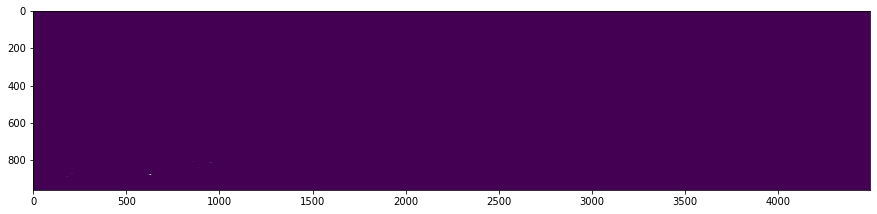

In [17]:
plt.figure(figsize=(15, 15))

plt.imshow(clear_image)
plt.show()

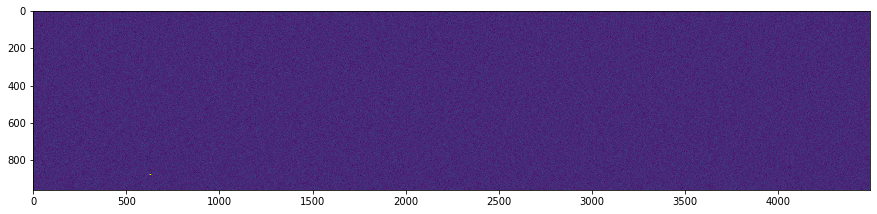

In [18]:
plt.figure(figsize=(15, 15))

plt.imshow(noised_image)
plt.show()

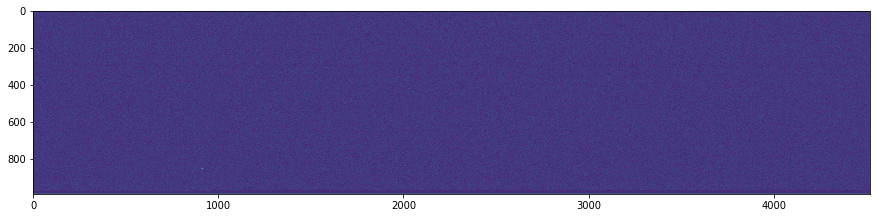

In [19]:
plt.figure(figsize=(15, 15))

plt.imshow(denoised_image)
plt.show()

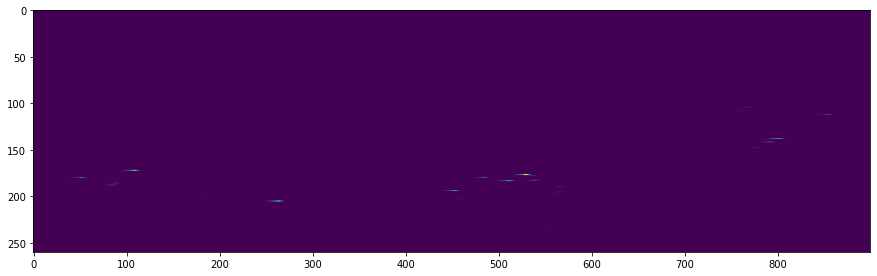

In [20]:
plt.figure(figsize=(15, 15))

plt.imshow(clear_image[700:1000, 100:1000])
plt.show()

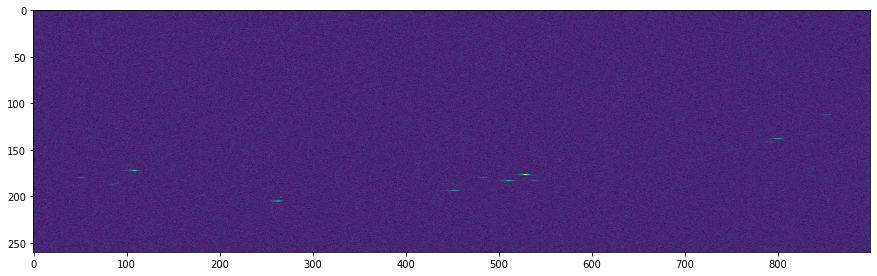

In [21]:
plt.figure(figsize=(15, 15))

plt.imshow(noised_image[700:1000, 100:1000])
plt.show()

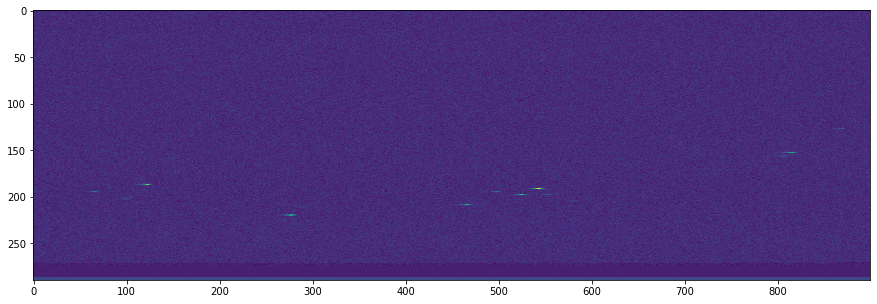

In [22]:
plt.figure(figsize=(15, 15))

plt.imshow(denoised_image[700:1000, 100:1000])
plt.show()